---
title: "LSE DS202W 2025: Week 5 - Student Notebook"
subtitle: "2024/25 Winter Term"
author: "The DS202 team"
date: 17 February 2025
---

# Loading packages and data

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import f1_score, root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lets_plot import *
LetsPlot.setup_html()

# Predicting who voted Brexit with *k* Nearest Neighbours (45 minutes)

Today, we are going to be demonstrating the utility of hyperparameter tuning using k-fold cross validation.

## Exploring a feature space

We are going to take a look at data adapted from the European Social Survey, round 8 (ESS8)^[European Social Survey European Research Infrastructure (ESS ERIC) (2023) ESS round 8 - 2016. Welfare attitudes, Attitudes to climate change. Sikt - Norwegian Agency for Shared Services in Education and Research. [https://doi.org/10.21338/NSD-ESS8-2016](https://doi.org/10.21338/NSD-ESS8-2016).]. 

The ESS is a an academically-driven multi-country survey. Its stated aims are "firstly – to monitor and interpret changing public attitudes and values within Europe and to investigate how they interact with Europe's changing institutions, secondly - to advance and consolidate improved methods of cross-national survey measurement in Europe and beyond, and thirdly - to develop a series of European social indicators, including attitudinal indicators". 

Aside from questions common to all countries, for this round of the survey, the data providers had asked participants from the UK questions around the recently-completed Brexit referendum and more specifically whether they had voted "Leave" (i.e "Brexit") or "Remain" in the Brexit. 

We will expand an example given for *k* nearest neighbours in (Garibay Rubio et al., 2024)^[Carlos Rodrigo Garibay Rubio, Katsuya Yamori, Genta Nakano, Astrid Renneé Peralta Gutiérrez, Silvia Morales Chainé, Rebeca Robles García, Edgar Landa-Ramírez, Alexis Bojorge Estrada, Alejandro Bosch Maldonado, Diana Iris Tejadilla Orozco, **Machine learning-ready mental health datasets for evaluating psychological effects and system needs in Mexico city during the first year of the COVID-19 pandemic**, *Data in Brief*,Volume 57,2024,110877,ISSN 2352-3409,[https://doi.org/10.1016/j.dib.2024.110877](https://doi.org/10.1016/j.dib.2024.110877)] (see page 10), using two predictors. 

The full (adapted) data set consists of:

-   `vtleave`: Whether or not a participant voted "Brexit" or "Remain"
-   `atchctr`: 0-10 attachment rating to the United Kingdom
-   `atcherp`: 0-10 attachment rating to Europe

In [3]:
brexit = pd.read_csv("data/brexit-ess.csv")

💡**Tip:** Don't worry too much about the below code.  All we are doing is creating a grid of potential values for illustration purposes.  We somewhat adapted the code for this from [here](https://dev.to/chrisgreening/completing-missing-combinations-of-categories-in-our-data-with-pandasmultiindex-26jn)!

In [4]:
unique_categories = [
    brexit['atchctr'].unique(), 
    brexit['atcherp'].unique()
]

names = ["atchctr", "atcherp"]

multiindex = pd.MultiIndex.from_product(
    unique_categories,
    names=names
)

brexit_grid = brexit.groupby(["atchctr","atcherp"]).mean().reset_index()

brexit_grid = (
    brexit_grid
    .set_index(names)
    .reindex(multiindex, fill_value = np.nan)
    .reset_index()
)

Let's use `ggplot` to explore this feature space.

In [5]:
(
  ggplot(brexit_grid, aes("atchctr", "atcherp", colour = "vtleave")) +
  geom_point(size = 5) +
  scale_x_continuous(breaks = np.arange(0,11,1)) +
  scale_y_continuous(breaks = np.arange(0,11,1)) +
  theme(panel_grid=element_blank(),
        legend_position="bottom") +
  labs(x = "Attachment to the United Kingdom", y = "Attachment to Europe",
       colour = "Proportion of grid that voted Brexit")
)

👉 **NOTE:** The actual data set has many features that can be used. We are only using 2 features as it is hard to visualise a feature space that has more than two dimensions.

🗣️ **CLASSROOM DISCUSSION:** What does this graph show? How can we identify individuals who voted Brexit? What boundaries can we draw between the two classes?

👨🏻‍🏫 **TEACHING MOMENT:** All machine learning algorithms can draw boundaries.

## Introducing *k* Nearest Neighbours

An algorithm that can be used to classify data points is *k* Nearest Neighbours (kNN for short). This algorithm works by taking the neighbours of an observation and having them "vote" on whether or not the observation in question belongs to a specific class.

👉 **NOTE:** The "neighbours" decide the fate of a data point based on them calculating their proximity to it in relation to other data points that do not belong to their neighbourhood.

The question is, **how many neighbours get to vote in the decision?** This is the key hyperparameter of nearest neighbours and something that we need to experiment with. The most widely acknowledged way to experiment with hyperparameters is via k-fold cross-validation.

## k-fold Cross-validation

Let's split our sample into training and testing sets.

## Pre-processing

We are going to use a simple function to pre-process the data. All that is happening is that both features are normalised, meaning we subtract the mean from each feature and divide by their standard deviation.

⚠️ **WARNING:** Any algorithm that uses distance metrics must use this preprocessing step as features with higher variances will play a disproportionately high amount of influence. So, when you hear "this algorithm utilizes distance measures", think "standardise features!"

:::callout-tip
Note that you could use `scikit-learn`'s `StandardScaler` method or `scipy.stats`'s `zscore` method to standardise data instead of your own custom function (see [here](https://www.geeksforgeeks.org/how-to-standardize-data-in-a-pandas-dataframe/) for details).
:::

In [7]:
# Create a function that normalises variables
def normalise(var):
  return (var-var.mean())/var.std()

# Drop the target from the features
X = brexit.drop("vtleave", axis = 1)

# Normalise features
X = X.apply(lambda x: normalise(x), axis=0)

# Convert features into a numpy array
X = X.to_numpy()

# Isolate the target
y = brexit["vtleave"]

# Create a train / test split
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,random_state=123)

The below code instantiates a kNN classifier.

In [15]:
knn_model = KNeighborsClassifier()

## Creating a nearest neighbours grid

We then need to specify a hyperparameter grid.

👉 **NOTE:** This task often involves a lot of experimentation so do not take these values to be gospel for any future kNN models you build.

In [16]:
grid_knn = {"n_neighbors":[5, 25, 100, 250]}

🗣️ **CLASSROOM DISCUSSION:** Which number in the grid would represent the most "complex" model?

👨🏻‍🏫 **TEACHING MOMENT:**

Your teacher will present some output to see what happens when we vary *k*.

In [ ]:
# Create a function that varies k in k-NN models
def vary_neighbours(n_neighbours, features, target):
  knn_model = KNeighborsClassifier(n_neighbors=n_neighbours)
  return knn_model.fit(features, target)

# Suggest a k grid
neigh_list = [5, 25, 100, 250]

# Loop model function of k grid
knn_models = [vary_neighbours(neighs, X, y) for neighs in neigh_list]

# Create a feature grid
brexit_feature_grid = brexit_grid.drop("vtleave",axis=1).to_numpy()
brexit_feature_grid = normalise(brexit_feature_grid)

# Apply predictions to grid
knn_grid_preds = [model.predict(brexit_feature_grid) for model in knn_models]

# Create a list of data frames of predictions
knn_grid_df = [pd.DataFrame({"preds": pred.astype(bool)}) for pred in knn_grid_preds]

# Append original feature values to list of predictions
knn_grid_df = [pd.concat([brexit_grid, pred], axis = 1) for pred in knn_grid_df]

# Concatenate to a single data frame
knn_grid_df = pd.concat(knn_grid_df, keys = neigh_list, names = ["k","n"])
knn_grid_df = knn_grid_df.reset_index().drop("n", axis = 1)


In [13]:
# Plot the output

(
  ggplot(knn_grid_df, aes("atchctr", "atcherp", colour = "vtleave")) +
  facet_wrap(facets = "k") +
  geom_point(size = 2) +
  geom_tile(aes("atchctr", "atcherp", fill = "preds"), alpha = 0.25) +
  scale_x_continuous(breaks = np.arange(0,11,1)) +
  scale_y_continuous(breaks = np.arange(0,11,1)) +
  theme(panel_grid=element_blank(),
        legend_position="bottom") +
  labs(x = "Attachment to the UK", y = "Attachment to Europe",
       colour = "Proportion Brexit vote",
       fill = "Predicted Brexit vote")
)


## Estimating a cross-validated model

We now have all the information we need to estimate a cross-validated model. We have

-   A k-NN model instantiation (`knn_model`)
-   A grid of hyperparameter options, expressed as a dictionary (`grid_knn`)

We can now add these as the first and second arguments of `GridSearchCV`, and specify the number of cross-validation folds, which we will set to 10. This will result in 40 different models being run (10-folds $\times$ 4 hyperparameter combinations).  We will ask `GridSearchCV` to return the f1-score to evaluate the different hyperparameter values.  We can then fit the `GridSearchCV` instantiation to the training data.

In [ ]:
# Code here

## Plot hyperparameters

After `knn_cv` compiles, locate the `cv_results_` attribute of the model object. Try plotting the mean f1-score of for each *k* using a plot of your choice.

💡**HINT:** If you are unsure as to how to get the data into the correct format, check out the `pandas` introduction in the week 1 lab.

In [1]:
# Code here

🗣️ **CLASSROOM DISCUSSION:** Which *k* is best?

## Fit the best model to the full training set

We can then build a final model using the best hyperparameter combination.

In [ ]:
# Select the best model


# Use the best parameter combination and fit on the entire training data


## Evaluate the model on the test set

From there, all we need to do is follow the evaluation step that we have done for previous models.

In [ ]:
# Create predictions from k-NN model for the test set


# Calculate f1-score


# Report the result


Our best k-NN model produces an f1-score of 0.71 on the test set!


# Predicting childcare costs in US counties with tree-based models (45 minutes)

We are going to implement a decision tree, Random Forest and an XGBoost.

## Exploring the data set

In [41]:
childcare = pd.read_csv("data/childcare-costs.csv")

Our target is `mcsa`, defined as "Weekly, full-time median price charged for Center-Based Care for those who are school age based on the results reported in the market rate survey report for the county or the rate zone/cluster to which the county is assigned."  Click [here](https://github.com/rfordatascience/tidytuesday/blob/master/data/2023/2023-05-09/readme.md) to see a full list of variables. Let's explore the data with a few visualisations.

## Create a grouped train / test split

If you have inspected `childcare`, you will see that it tracks 1,786 counties from 2008 to 2018. 

📝**Task:** Create a train / test split using all years up to 2018 to train the model and 2018 to test the model.

In [ ]:
# Create a list of all variables with "county" or "state" as a prefix using a logical condition


# Use the above list to drop these variables from the data set


# Use 2018 to test and all other years to train


# Split the data set into features / target




## Decision trees

Fit a decision tree that has a maximum depth of three levels using the appropriate function (see the first code chunk).  Next, use the `plot_tree` function on the model, setting the feature names to the column names.

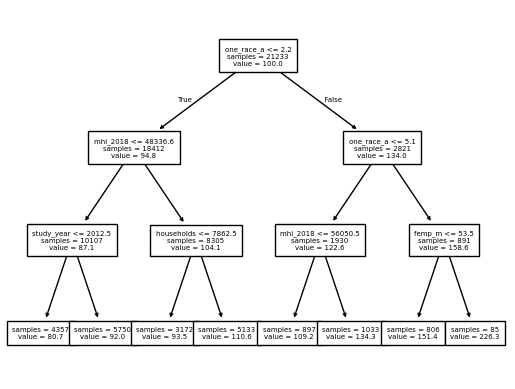

In [ ]:
# Instantiate a decision tree for regression


# Fit the model to the training data


# Plot the output


🗣️ **CLASSROOM DISCUSSION:** Which feature has the algorithm deemed most important for splitting the data? Can you explain what the tree is doing?

## Evaluate the model on the test set

Let's see how well our simple decision tree does. Here's a function that takes five parameters:

-   `model` takes a `scikit-learn` model object
-   `test_features` takes a `pandas` data frame or a `numpy` array of test features
-   `true_values` takes a `pandas` data frame or a `numpy` array of test outcomes
-   `model_name` takes a user-created string that specifies the model used
-   `index` takes an integer value

The output is a 1-row data frame which shows the name of the model and it's associated RMSE on the test set.

In [33]:
def metric_to_df(model, test_features, true_values, model_name, index):
  preds = model.predict(test_features)
  rmse = np.round(root_mean_squared_error(true_values,preds), 0)
  return pd.DataFrame({"model":model_name, "rmse":rmse}, index=[index])

Try using this function on the model we have built above.

In [2]:
# Code here

## Instantiate a random forest model

-   Take a look at the library code chunk at the beginning of the notebook and instantiate the relevant model.
    -   Set `max_features = "sqrt"`
    -   Set `n_estimators = 1000`

🗣️ **CLASSROOM DISCUSSION:** Why do we do this? What happens if we set `max_features` equal to `sqrt`?

-   Fit the model to the training data.
-   Evaluate the model on the test set.

In [ ]:
# Instantiate a random forest with the required hyperparameters


# Fit the model to the training data


In [3]:
# Evaluate on the test data



🗣️ **CLASSROOM DISCUSSION:** Do we see an improvement?

*Yes, and quite a dramatic one! Test RMSE is reduced from $34 to $25.*

## Instantiate an XGBoost model

-   Take a look at the library code chunk at the beginning of the notebook and instantiate the relevant model.
    -   Set `n_estimators = 1000`
    -   Set `colsample_bytree = 0.135`
    -   Set `learning_rate = 0.1`

In [ ]:
# Instantiate an XGBoost with the required hyperparameters


# Fit the model to the training data


In [ ]:
# Evaluate on the test data


model  rmse
2  XGBoost  24.0

🗣️ **CLASSROOM DISCUSSION:** Do we see an improvement?

*Yes, but only modestly if we compare to the random forest. Test RMSE is only reduced from $25 to $24!*

## Which model is best?

Create a summary of your findings using either a table or a graph.

In [4]:
# Code here